# Initializing sythesis with image

This notebook shows how to initialize $Z$ with image using VQGAN encoder instead of starting with random codes.

In [9]:
import sys
sys.path.append("../")

# Workaround problems with downloading some models from pytorch hub.
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import os
import torch
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
from torch import nn, optim
from synth.synth import *
from synth.agumenter import Agumenter
from synth.objective import ObjectiveCLIP, SimplePrompt

## Loading models

In [2]:
device = torch.device("cuda:0")
#device = torch.device("cpu") # CPU

m_file = lambda file: os.path.join(os.getenv("MODEL_STORE"), file)
CLIP_MODEL_FILEPATH = m_file("ViT-B-32.pt")
VQGAN_CONFIG_FILEPATH = m_file("vqgan_imagenet_f16_16384.yaml")
VQGAN_CHECKPOINT_FILEPATH = m_file("vqgan_imagenet_f16_16384.ckpt")
VQGAN_MODEL_TYPE = "unconditional"

model_clip, clip_preprocessor = load_clip(CLIP_MODEL_FILEPATH, device)
model_vqgan = load_vqgan(VQGAN_CHECKPOINT_FILEPATH,
                         VQGAN_CONFIG_FILEPATH,
                         device,
                         model_type=VQGAN_MODEL_TYPE)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from /workspace/weights/vqgan_imagenet_f16_16384.ckpt


## Hyperprameters and objecive

In [3]:
TARGET_IMAGE_SIZE = 512
LR = 0.1
N_ITER = 100
CUTN = 400

PROMPTS = [SimplePrompt.make_from_text("Landscape covered in colorfull rocks.", 1.0, model_clip, device)]


objective = ObjectiveCLIP(PROMPTS, Agumenter(device, CUTN), model_clip, device)

## Initialize Z from image file

We load image from file and if necessary we resize it to the desired size of the output from VQGAN. Then we convert it to tensor, unsqueeze and we process it so
pixel values are between -1 and 1 instead of between 0 and 1.
Then we encode it using VQGAN encoder stage to get $Z$ tensor.

In [4]:
def z_from_image(img, img_size, model_vqgan, device):
    if isinstance(img, str):
        img = Image.open(img)
    
    assert img.size[0] == img.size[1]
    
    if img.size[0] != img_size:
        img = img.resize((img_size, img_size))

    img = torch.unsqueeze(ToTensor()(img), 0).to(device)
    img = 2.0*img - 1.0
    
    return model_vqgan.encode(img)[0]

z = z_from_image("samples/mountains.jpg", TARGET_IMAGE_SIZE, model_vqgan, device)
z.requires_grad_(True)
opt = optim.Adam([z], lr=LR)

## Run synthesis

In [5]:
filepath = run(opt, z, objective, model_vqgan, model_clip, N_ITER, save_interval=1)

100% 100/100 [01:08<00:00,  1.46it/s, loss=-.428]


Text(0.5, 1.0, 'Before')

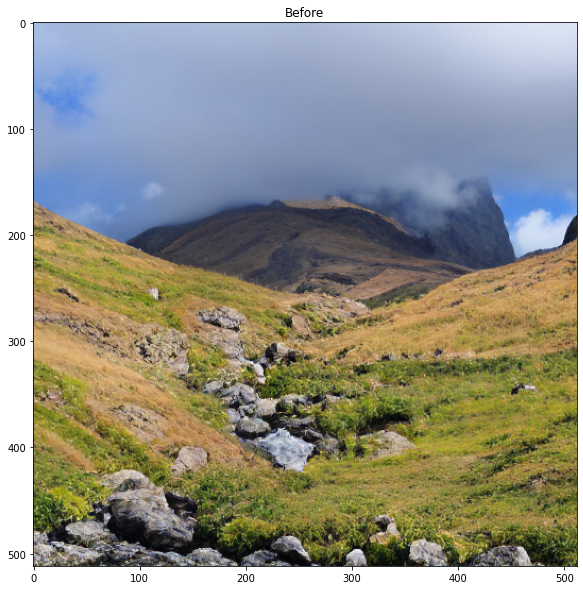

In [6]:
plt.figure(figsize = (10,10))
img = plt.imread("img/0.png")
plt.imshow(img)
plt.title("Before")

Text(0.5, 1.0, 'After')

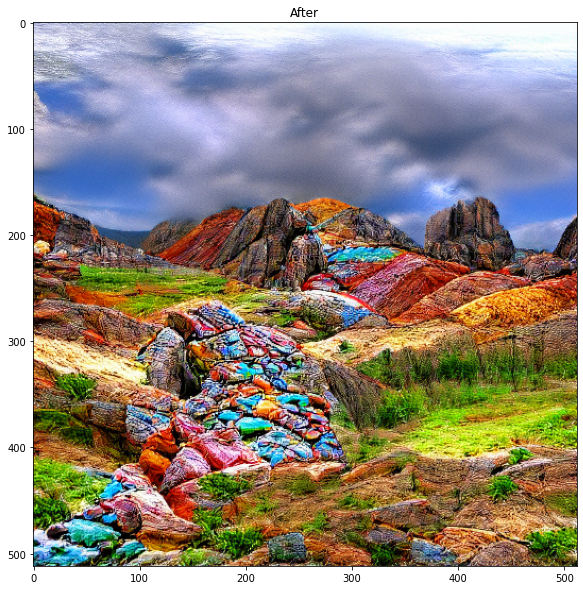

In [7]:
plt.figure(figsize = (10,10))
img = plt.imread(filepath)
plt.imshow(img)
plt.title("After")

In [8]:
objective.print_objective_loss_report()

╒═══════════════════════════════════════╤═══════════╤══════════════╤═════════════════════════╕
│ Prompt                                │ Exclude   │   Final loss │   Unweighted final loss │
╞═══════════════════════════════════════╪═══════════╪══════════════╪═════════════════════════╡
│ Landscape covered in colorfull rocks. │ False     │    -0.427734 │               -0.427734 │
╘═══════════════════════════════════════╧═══════════╧══════════════╧═════════════════════════╛
